# 複数の説明変数を持つモデル

複数の説明変数を持っていても、正規線形モデルという枠組みで統一的な分析・解釈・予測が可能。

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 分析対象となる売上データ
# 説明変数に湿度、価格、気温、天気を持つ。（天気はカテゴリ型変数）
sales = pd.read_csv('multi_expranatory_variables.csv')
sales.head()

,humidity,price,sales,temperature,weather
0,29.5,290,229.7,17.8,rainy
1,38.1,290,206.1,26.1,rainy
2,31.5,290,202.5,22.0,rainy
3,39.7,290,195.5,23.0,rainy
4,24.7,290,214.4,14.5,rainy


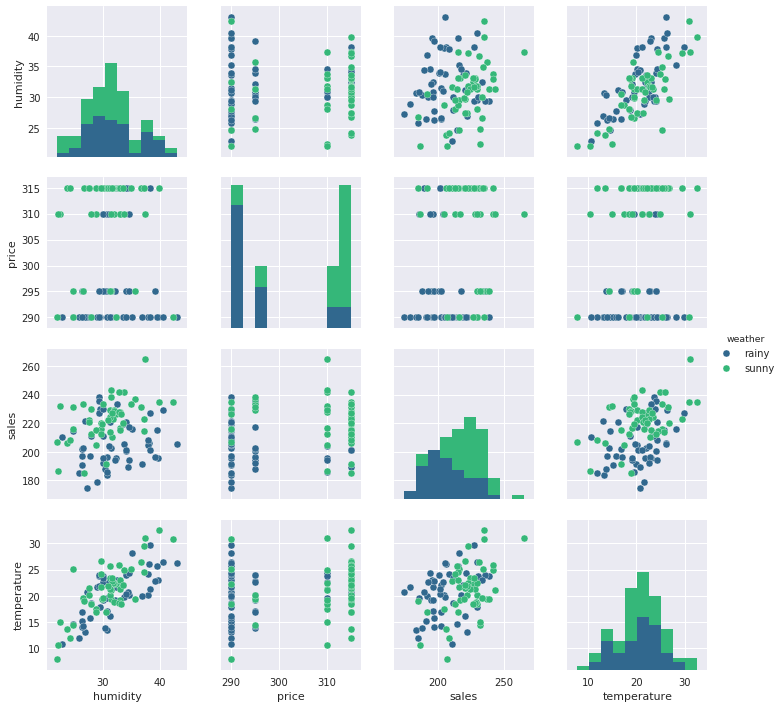

In [3]:
# 説明変数が複数あるため、ペアプロットで図示する
sns.pairplot(data=sales, hue='weather', palette='viridis')

----

## ■ 悪い分析例：変数がひとつだけのモデルを作る

複数の説明変数が必要であるのに、ひとつだけを選んで使う例


In [4]:
lm_bad_example = smf.ols(formula='sales ~ price', data=sales).fit()
lm_bad_example.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.971
Date:                Mon, 13 Aug 2018   Prob (F-statistic):             0.0281
Time:                        02:40:38   Log-Likelihood:                -422.86
No. Observations:                 100   AIC:                             849.7
Df Residuals:                      98   BIC:                             854.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.6454     45.187      2.515      0.014      23.973     203.318
price          0.3328      0.149      2.230      0.028       0.037       0.629
==============================================================================
Omnibus:                        0.527   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.651
Skew:                          -0.024   Prob(JB):                        0.722
Kurtosis:                       2.608   Cond. No.                     8.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

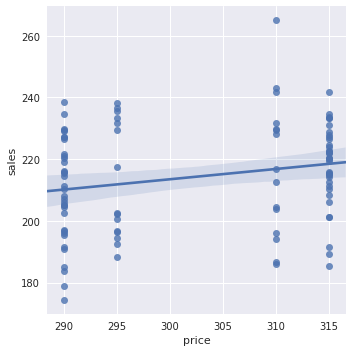

In [5]:
sns.lmplot(
    x='price',
    y='sales',
    data=sales
)

In [6]:
# 分析結果だけ見ると、価格を上げると売上が増える・と判断できるが、果たして本当にそうなのか

# 天気別の売上の平均値を見てみる
sales.groupby('weather').mean()

,humidity,price,sales,temperature
weather,,,,
rainy,32.126,295.5,205.924,20.422
sunny,30.852,309.5,222.718,21.102


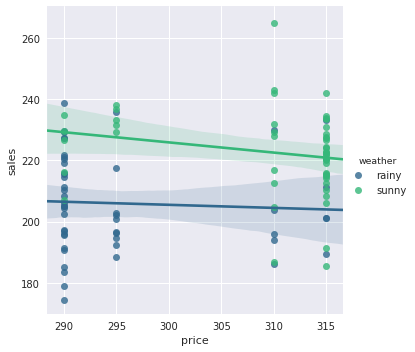

In [7]:
# 雨の日は売上が下がるので、価格も下げている（値引きしている）のではないか・と考えられる
# そのため「天気が同じだった時の」商品価格が売上にもたらす影響を確認してみる
sns.lmplot(
    x='price',
    y='sales',
    data=sales,
    hue='weather',
    palette='viridis'
)

# 結果を確認すると、晴れの日の方が相対的に高い売上となっており、かつ
# 天気別でみると「価格が高くなると、売上が下がっている」という逆の結果が得られた

# ひとつの説明変数だけを用いて断片的な情報から結論付けることは危険である

----

## ■ 複数の説明変数を持つモデルを作る


In [8]:
lm_sales = smf.ols(
    formula='sales ~ weather + humidity + temperature + price',
    data=sales
).fit()
lm_sales.summary()

# やはり価格が上がると売上が下がっていることが分かる（係数が負）

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     16.15
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           4.01e-10
Time:                        02:40:41   Log-Likelihood:                -399.39
No. Observations:                 100   AIC:                             808.8
Df Residuals:                      95   BIC:                             821.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          278.6277     46.335      6.013      0.000     186.641     370.615
weather[T.sunny]    19.9891      3.522      5.675      0.000      12.997      26.982
humidity            -0.2541      0.456     -0.558      0.578      -1.159       0.651
temperature          1.6031      0.443      3.620      0.000       0.724       2.482
price               -0.3292      0.155     -2.123      0.036      -0.637      -0.021
==============================================================================
Omnibus:                        0.160   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.016
Skew:                          -0.028   Prob(JB):                        0.992
Kurtosis:                       3.027   Cond. No.                     1.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# 説明変数が有意に応答変数に影響を与えているかどうかを分散分析で確認する
sm.stats.anova_lm(lm_sales, typ=1).round(3)

# p-value < 0.05 なので、全ての説明変数が有意であるとの結果が出た
# 湿度に関して、t検定の結果と分散分析の結果が異なるが本当か？

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
humidity,1.0,1779.601,1779.601,9.805,0.002
temperature,1.0,2076.845,2076.845,11.443,0.001
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


----

## ■ 悪い分析例：通常の分散分析で検定する

複数の説明変数を持つ場合、Type I ANOVA を用いて検定を行った検定結果は誤っている可能性がある。<br>
Type I ANOVA は説明変数を入れる順番を変えると、検定の結果が変わってしまう。


In [10]:
# 検証のために、順番を変えた同一の説明変数を持つ正規線形モデルを作成する

# cf) 最初の正規線形モデルの説明変数
# formula='sales ~ weather + humidity + temperature + price',

lm_sales_another = smf.ols(
    formula='sales ~ weather + temperature + humidity + price',
    data=sales
).fit()
lm_sales_another.summary()

# t検定の結果は変わらない（あくまでもその説明変数を組み込むか否かの検定を行っているため順番には左右されない）

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     16.15
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           4.01e-10
Time:                        02:40:41   Log-Likelihood:                -399.39
No. Observations:                 100   AIC:                             808.8
Df Residuals:                      95   BIC:                             821.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          278.6277     46.335      6.013      0.000     186.641     370.615
weather[T.sunny]    19.9891      3.522      5.675      0.000      12.997      26.982
temperature          1.6031      0.443      3.620      0.000       0.724       2.482
humidity            -0.2541      0.456     -0.558      0.578      -1.159       0.651
price               -0.3292      0.155     -2.123      0.036      -0.637      -0.021
==============================================================================
Omnibus:                        0.160   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.016
Skew:                          -0.028   Prob(JB):                        0.992
Kurtosis:                       3.027   Cond. No.                     1.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# 説明変数の順番を入れ替えたモデルでは、湿度の説明変数が売上に有意な影響を与えない・と結果づけている
sm.stats.anova_lm(lm_sales_another, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
temperature,1.0,3814.779,3814.779,21.018,0.000
humidity,1.0,41.667,41.667,0.230,0.633
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


----

## ■ 複数の説明変数を持つモデルの分散分析

説明変数の順番に依らず検定の結果が変わらない分散分析を Type II ANOVA という。

「説明変数が減ることによって増加する残差平方和の大きさ」に基づいて、「説明変数の持つ効果の大きさ」を計算する。


【イメージ】

| モデルNo. | 応答変数 | 説明変数 | 残差平方和 |
|:--|:--|:--|:--|
| model_0 | sales ~ | weather + humidity + temperature + price | resid_0 |
| model_1 | sales ~ | 　　　　　　humidity + temperature + price | resid_1 |
| model_2 | sales ~ | weather　　　　　　 + temperature + price | resid_2 |
| model_3 | sales ~ | weather + humidity 　　　　　　　 + price | resid_3 |
| model_4 | sales ~ | weather + humidity + temperature  　 　    　 | resid_4 |

resid_0 と resid_1 の比較、resid_0 と resid_2 の比較・・・というように総当たりで説明変数の有意性を検定していく。

In [13]:
# すべての説明変数を入れたモデル（lm_sales と同じ）
lm_sales_all = smf.ols(
    formula='sales ~ weather + humidity + temperature + price',
    data=sales
).fit()
sm.stats.anova_lm(lm_sales_all, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,5845.878,1.0,32.208,0.000
humidity,56.425,1.0,0.311,0.578
temperature,2378.017,1.0,13.102,0.000
price,818.402,1.0,4.509,0.036
Residual,17242.717,95.0,NaN,NaN


In [23]:
# すべての説明変数を入れたモデルの残差平方和
resid_sq_all = sp.sum(lm_sales_all.resid ** 2)

In [27]:
# 湿度を除いたモデルの残差平方和
lm_non_humid = smf.ols(
    formula='sales ~ weather + temperature + price',
    data=sales
).fit()

resid_sq_non_humid = sp.sum(lm_non_humid.resid ** 2)

sm.stats.anova_lm(lm_non_humid, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,6354.966,1.0,35.266,0.000
temperature,4254.736,1.0,23.611,0.000
price,803.644,1.0,4.460,0.037
Residual,17299.142,96.0,NaN,NaN


In [26]:
# 残差平方和の差
resid_sq_non_humid - resid_sq_all

56.42507374116394

----

## Type II ANOVA の解釈

他の説明変数が存在している状況で、それでも湿度は売上に有意な影響を及ぼしていると判断できるか・を分析したと解釈できる。<br>
その意味で、湿度を除いたことでモデルが失う表現力はほとんどない（残差平方和の差が小さい）。

ペアプロットを見る限り、湿度と気温には強い相関関係がある。（多重共線性）<br>
そのため「気温という説明変数がモデルに含まれていると、湿度は売上に影響を与えているとは見なせなくなる」という状況がありうる。<br>
言い換えると、「気温という説明変数で、湿度が売上に与える影響も表現できている」という状況がありうる。

## 変数選択

有意でない説明変数をすべて取り除いた状況になって初めて、変数選択が終了したと言える。<br>
今回は lm_non_humid がモデルとして用いられる。

AIC を用いた変数選択の場合は、分散分析のように計算方法にケアする必要はない。<br>
愚直に総当たりでモデルごとの AIC を比較していき、 AIC の小さいモデルを用いれば良い。    

In [28]:
print('lm_sales_all: {:.3f}'.format(lm_sales_all.aic))
print('lm_non_humid: {:.3f}'.format(lm_non_humid.aic))

lm_sales_all: 808.785
lm_non_humid: 807.112


----

## 参考

#### ・Type I ANOVA の残差平方和の比較方法

```
sales ~ 1 + weather + humidity + temperature + price
```

複数の説明変数を持つ場合の Type I ANOVA での分散分析は、説明変数をひとつずつ増やしていき、<br>
「説明変数が増えたことによって減少する残差平方和の大きさ」に基づいて、「説明変数の持つ効果の大きさ」を計算する。（分散分析表の sum_sq）

この方法だと、説明変数を増やしていく順番によって sum_sq の値が変わるため、ある説明変数が有意であるか否かという判断が変わることがある。

【イメージ】

| モデルNo. | 応答変数 | 説明変数 | 残差平方和 |
|:--|:--|:--|:--|
| model_0 | sales ~ | Null | resid_0 |
| model_1 | sales ~ | weather | resid_1 |
| model_2 | sales ~ | weather + humidity | resid_2 |
| model_3 | sales ~ | weather + humidity + temperature | resid_3 |
| model_4 | sales ~ | weather + humidity + temperature + price | resid_4 |

resid_0 と resid_1 の比較、resid_1 と resid_2 の比較・・・というように各々の説明変数の有意性を検定していく。


In [14]:
# 説明変数をひとつずつ増やしていく

# ① Null モデル
model_null = smf.ols(formula='sales ~ 1', data=sales).fit()

# 残差平方和
resid_sq_null = sp.sum(model_null.resid ** 2)

In [15]:
# ②天気を加えたモデル
model_weather = smf.ols(formula='sales ~ weather', data=sales).fit()

# 残差平方和
resid_sq_weather = sp.sum(model_weather.resid ** 2)

In [16]:
# 残差平方和の差（② - ①）
# 天気が説明変数に加わることによって減少する残差平方和
print(resid_sq_null - resid_sq_weather)

# 分散分析表にも表れる
sm.stats.anova_lm(model_weather, typ=1)

7050.960899999995


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.9609,7050.960900,31.526959,1.836060e-07
Residual,98.0,21917.5650,223.648622,NaN,NaN


In [17]:
# ③湿度を加えたモデル
model_weather_humid = smf.ols(formula='sales ~ weather + humidity', data=sales).fit()

# 残差平方和
resid_sq_weather_humid = sp.sum(model_weather_humid.resid ** 2)

In [18]:
# 残差平方和の差（③ - ②）
# 湿度が説明変数に加わることによって減少する残差平方和
print(resid_sq_weather - resid_sq_weather_humid)

# 分散分析表にも表れる
sm.stats.anova_lm(model_weather_humid, typ=1).round(3)

1779.6011021482373


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,33.963,0.000
humidity,1.0,1779.601,1779.601,8.572,0.004
Residual,97.0,20137.964,207.608,NaN,NaN


In [19]:
model_weather_humid_temp = smf.ols(formula='sales ~ weather + humidity + temperature', data=sales).fit()

resid_weather_humid_temp = sp.sum(model_weather_humid_temp.resid ** 2)
print(resid_sq_weather_humid - resid_weather_humid_temp)

# 天気 + 湿度 + 気温 の順に説明変数を加えると、湿度は有意である・という結果になる
sm.stats.anova_lm(model_weather_humid_temp, typ=1).round(3)

2076.8445362633283


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.478,0.000
humidity,1.0,1779.601,1779.601,9.459,0.003
temperature,1.0,2076.845,2076.845,11.039,0.001
Residual,96.0,18061.119,188.137,NaN,NaN


In [20]:
# ここで②から fork して、先に気温を加えたモデルを作る
# ③' 気温を加えたモデル
model_weather_temp = smf.ols(formula='sales ~ weather + temperature', data=sales).fit()

# 残差平方和
resid_sq_weather_temp = sp.sum(model_weather_temp.resid ** 2)

In [21]:
# ④ ③' に湿度を加えたモデル
model_weather_temp_humid = smf.ols(formula='sales ~ weather + temperature + humidity', data=sales).fit()

# 残差平方和
resid_sq_weather_temp_humid = sp.sum(model_weather_temp_humid.resid ** 2)

In [22]:
# ③' と④の残差平方和の差を求めると、
# ③'「天気 + 気温」のモデルに湿度を加えたことによって減少した残差平方和が算出できる
print(resid_sq_weather_temp - resid_sq_weather_temp_humid)

# 天気 + 気温 + 湿度 の順に説明変数を加えると、湿度は有意とは言えない・という結果になる
sm.stats.anova_lm(model_weather_temp_humid, typ=1).round(3)

41.66706512379096


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.478,0.000
temperature,1.0,3814.779,3814.779,20.277,0.000
humidity,1.0,41.667,41.667,0.221,0.639
Residual,96.0,18061.119,188.137,NaN,NaN
